**파이토치 기본 제공 데이터 사용**


In [1]:
import torch # 파이토치 기본 라이브러리
import torchvision # 이미지 관련 된 파이토치 라이브러리
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt

In [2]:
transf = tr.Compose([tr.Resize(16), tr.ToTensor()])    # 16*16으로 이미지 타입 변환 후 텐서 타입으로 변환!!

# torchvision.datasets에서 기본 제공하는 CIFAR10 데이터 불러옴
# root에는 다운로드 받을 경로를 입력한다.
# train=Ture이면 학습 데이터를 불러오고 train=False이면 테스트 데이터를 불러온다.
# 미리 선언한 전처리를 사용하기 위해 transform=transf을 입력한다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transf)

100%|██████████| 170498071/170498071 [00:02<00:00, 58714203.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


일반적으로 데이터셋은 이미지, 라벨이 동시에 들어있는 튜플 형태이다!!

trainset[0]: 1st 데이터 - 이미지 한장([0][0]) + 라벨 숫자 하나([0][1])

In [3]:
print(trainset[0][0].size())

torch.Size([3, 16, 16])


RGB: 너비 * 높이 * 채널 수

파이토치: 채널 수 * 너비 * 높이

In [4]:
# DataLoader는 데이터를 미니 배치 형태로 만들어 준다.
# 따라서 배치 사이즈 및 셔플 여부 등을 선택할 수 있다.
trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
testloader = DataLoader(testset, batch_size=50, shuffle=False)

In [8]:
len(trainloader)

1000

In [10]:
# iter, next를 이용해 일부 데이터를 확인할 수 있다.
images, labels = next(iter(trainloader))
print(images.size())
# 일반적으로 학습 데이터는 4차원 형태로 모델에서 사용된다.
# (배치 크기)x(채널 수)x(너비)x(높이)

torch.Size([50, 3, 16, 16])


https://dacon.io/forum/407531



_SingleProcessDataLoaderIter' object has no attribute 'next' 오류 해결



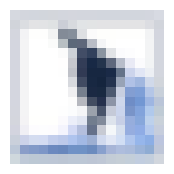

In [12]:
# 그림 그리기 위해 채널 수를 가장 뒤로 보낸다
oneshot = images[1].permute(1,2,0).numpy()
plt.figure(figsize=(2,2))
plt.imshow(oneshot)
plt.axis("off")
plt.show()

**같은 클래스 별로 폴더를 정리한 경우**

--> ImageFolder 하나로 개인 데이터 사용 가능!!

별도의 라벨링 필요 X, 폴더 별 자동 라벨링!!

In [16]:
cd/content/drive/MyDrive/Pytorch_sample

/content/drive/MyDrive/Pytorch_sample


In [17]:
transf = tr.Compose([tr.Resize(128), tr.ToTensor()])    # 128*128로 이미지 타입 변환 후 텐서 타입으로 변환!!
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf) # 커스텀 데이터 불러온다.
trainloader = DataLoader(trainset, batch_size=2, shuffle=False) # 데이터를 미니 배치 형태로 만들어 준다.

**정리 안 된 커스텀 데이터 불러오기**

In [19]:
# 32*32 크기의 RGB 컬러 이미지 100장, 그에 대한 라벨이 넘파이 형태로 정리되어 있다고 치자

train_images = np.random.randint(256,size=(100,32,32,3))/255 # (이미지 수)x(너비)x(높이)x(채널 수)
train_labels = np.random.randint(2,size=(100,1)) # 라벨 수

# 이미지 전처리 작업이 필요할 경우 openCV와 같은 라이브러리를 이용하여 이 곳에서 작업할 수도 있다.
# 필자는 이 단계에서 전처리하는 것을 선호한다. 그 이유는 torchvision.transforms 라이브러리 보다
# OpenCV, SciPy와 같은 라이브러리가 더 많은 전처리 기술을 제공하며 이미지를 미리 처리해 놓고 전처리 된 이미지를 살펴보면서
# 작업하는 것을 좋아하기 때문이다. 따라서 사용 목적과 편의성에 맞게 본인이 전처리를 어디서 할 지 정하면 될 것이다.

In [23]:
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data) # 이미지 데이터 to FloatTensor
        self.x_data = self.x_data.permute(0,3,1,2)  # (이미지 수)x(너비)x(높이)x(채널 수) -> (배치 크기)x(채널 수)x(너비)x(높이)
        self.y_data = torch.LongTensor(y_data)  # 라벨 데이터 to LongTensor
        self.len = self.y_data.shape[0] # 클래스 내 들어온 데이터 개수

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] # 뽑아 낼 데이터를 적어준다.

    def __len__(self):
        return self.len # 클래스 내의 들어 온 데이터 개수

# 파이토치에서는 (배치 크기)x(채널 수)x(너비)x(높이) 데이터가 사용 되므로 원래 데이터 (이미지 수)x(너비)x(높이)x(채널 수)를 변경해야만 한다.
# permute에서 0(이미지 수), 1(너비),2 (높이), 3(채널 수)을 0(이미지 수), 3(채널 수), 1(너비),2 (높이)로 바꿔주는 것이기 때문에
# .permute(0,3,1,2)을 사용하는 것이다.

In [24]:
train_data = TensorData(train_images,train_labels) # 텐서 데이터 불러오기
train_loader = DataLoader(train_data, batch_size=10, shuffle=True) # 미니 배치 형태로 데이터 갖추기